In [1]:
import numpy as np
import matplotlib.pyplot as plt

data = 'a9a'
K = 10001
batch_size = 32
full_grad = 1000
num_of_nodes = 8
report = 100
trial_num = 5
eval_idx = [i for i in range(0, K, report)]
samples_in_total = {'a9a': 32561, 'miniboone': 100000, 'mnist': 60000}
samples_per_node = samples_in_total[data] // num_of_nodes
epoch_per_iter = batch_size / samples_per_node
name_mapping = {'dsgt': 'D-SGT', 'dsgd': 'D-SGD', 'proxdasagt': 'D-ASA-GT',  'proxndasagt': 'D-NASA'}
# algorithms = ['sppdm', 'proxgtsr', 'deepstormv2', 'proxdasa', 'proxdasagt']
algorithms = ['dsgt', 'dsgd', 'proxdasagt', 'proxndasagt']
best_lr_list = {'dsgt': '10.0', 'dsgd': '10.0', 'proxdasagt': '20.0',  'proxndasagt': '1.0'}


# color_list = ['lightcoral', 'burlywood', 'lightseagreen', 'yellowgreen', 'blue']
# shadow_list = ['gainsboro', 'bisque', 'springgreen', 'yellow', 'cyan']

color_list = [(0, 158/255, 115/255), (86/255, 180/255, 233/255), 'burlywood', 'darkviolet', 'darkred']
shadow_list = [(178/255, 225/255, 212/255), (203/255, 232/255, 248/255), 'bisque', 'violet', 'lightcoral']

marker_list = ['*', 's', '^', 'o', '']

results_prefix = f'results/{data}/'

In [2]:
algo_num, idx_num = len(algorithms), len(eval_idx)

a9a_acc = np.zeros((trial_num, algo_num, idx_num))
a9a_train_loss = np.zeros((trial_num, algo_num, idx_num))
a9a_test_loss = np.zeros((trial_num, algo_num, idx_num))
a9a_stat = np.zeros((trial_num, algo_num, idx_num))
a9a_time = np.zeros((trial_num, algo_num, idx_num))
a9a_comm_time = np.zeros((trial_num, algo_num, idx_num))
a9a_comp_time = np.zeros((trial_num, algo_num, idx_num))

for j, algo in enumerate(algorithms):
    for i in range(trial_num):
        result = np.load(results_prefix + '{}_t_{}_random_{}_{}_lr_{}.npy'.format(algo, i+1, batch_size, K, best_lr_list[algo]), allow_pickle=True)
        if algo in ['dsgt', 'dsgd']:
            for idd, res in enumerate(result):
                if len(res) == len(eval_idx) + 1:
                    result[idd] = res[1:]
        
        a9a_test_loss[i][j] = result[0]
        a9a_acc[i][j] = result[1]
        a9a_train_loss[i][j] = result[2]
        a9a_stat[i][j] = result[8]
        time = result[12]
        comm_time = result[13]
        comp_time = result[14]
        for k in range(K // report + 1):
            a9a_time[i][j][k] = sum(time[: k*report])
            a9a_comm_time[i][j][k] = sum(comm_time[: k*report])
            a9a_comp_time[i][j][k] = sum(comp_time[: k*report])

In [3]:
a9a_acc_avg = np.mean(a9a_acc, axis=0)
a9a_acc_std = np.std(a9a_acc, axis=0)
a9a_train_loss_avg = np.mean(a9a_train_loss, axis=0)
a9a_train_loss_std = np.std(a9a_train_loss, axis=0)
a9a_test_loss_avg = np.mean(a9a_test_loss, axis=0)
a9a_test_loss_std = np.std(a9a_test_loss, axis=0)
a9a_stat_avg = np.mean(a9a_stat, axis=0)
a9a_stat_std= np.std(a9a_stat, axis=0)
a9a_time_avg = np.mean(a9a_time, axis=0)
a9a_time_std = np.std(a9a_time, axis=0)

a9a_comm_time_avg = np.mean(a9a_comm_time, axis=0)
a9a_comp_time_avg = np.mean(a9a_comp_time, axis=0)

In [4]:
a9a_acc_avg[:,-1], a9a_train_loss_avg[:,-1], a9a_stat_avg[:,-1]

(array([85.14496314, 85.14496314, 85.11425061, 84.997543  ]),
 array([0.32592034, 0.32595071, 0.32459457, 0.32039802]),
 array([0.00026743, 0.00066217, 0.00040595, 0.00114501]))

In [5]:
# obtain the data used for the table
comm_per_iter, comp_per_iter, time_per_iter = [], [], []
comm_total, comp_total, time_total = [], [], []
for i, algo in enumerate(algorithms):
    comm_per_iter.append(a9a_comm_time_avg[i][-1] / K)
    comp_per_iter.append(a9a_comp_time_avg[i][-1] / K)
    time_per_iter.append(a9a_time_avg[i][-1] / K)
    comm_total.append(a9a_comm_time_avg[i][-1])
    comp_total.append(a9a_comp_time_avg[i][-1])
    time_total.append(a9a_time_avg[i][-1])

In [6]:
comm_per_iter, comp_per_iter, time_per_iter

([0.00177365663433626,
  0.0017797740225974214,
  0.002572594740526297,
  0.002560391960804222],
 [0.008506661333865972,
  0.008485625437455579,
  0.008654274572542553,
  0.0087803719628028],
 [0.010280317968202776,
  0.010265399460053466,
  0.01122686931306882,
  0.01134076392360773])

In [7]:
comm_total, comp_total, time_total

([17.738339999996935, 17.79951999999681, 25.7285200000035, 25.606480000003028],
 [85.07511999999357, 84.86473999999325, 86.55139999999808, 87.8124999999908],
 [102.81345999999596,
  102.66425999999471,
  112.27992000000127,
  113.41898000000091])

In [8]:
proxgtsr_epoch_list, epoch_list, epochs = [], [], 0
epoch_per_report = report * epoch_per_iter
for i in range(0, K, report):
    epoch_list.append(epochs)
    proxgtsr_epoch_list.append(epochs + (i // full_grad))
    epochs += epoch_per_report
# gtsr_cut_off = 0
# while proxgtsr_epoch_list[gtsr_cut_off] < 20:
#     gtsr_cut_off += 1
gtsr_cut_off = 100

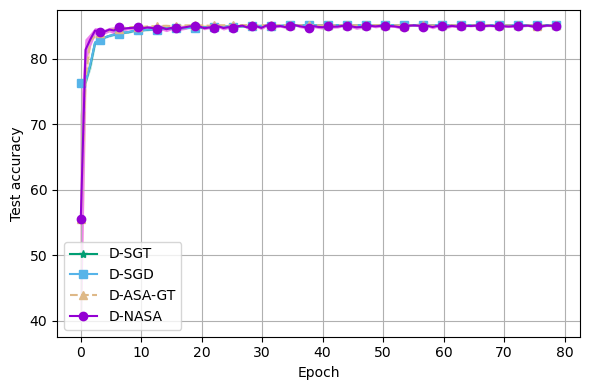

In [9]:
# test accuracy vs. epoch
for data in ['a9a']:
    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
    plt.xlabel('Epoch')
    ax.set_ylabel('Test accuracy')
    for k, algo in enumerate(algorithms):
        if algo == 'proxdasagt':
            plt.plot(epoch_list, a9a_acc_avg[k], '--', markevery=4, marker=marker_list[k], \
                     label=name_mapping[algo], color=color_list[k])
            plt.fill_between(epoch_list, \
                    a9a_acc_avg[k]-1.96 * a9a_acc_std[k] / np.sqrt(10), \
                    a9a_acc_avg[k]+ 1.96 * a9a_acc_std[k]/np.sqrt(10), color=shadow_list[k])
        elif algo != 'proxgtsr':
            plt.plot(epoch_list, a9a_acc_avg[k], markevery=4, marker=marker_list[k], label=name_mapping[algo], color=color_list[k])
            plt.fill_between(epoch_list, \
                    a9a_acc_avg[k]-1.96 * a9a_acc_std[k] / np.sqrt(10), \
                    a9a_acc_avg[k]+ 1.96 * a9a_acc_std[k]/np.sqrt(10), color=shadow_list[k])
        else:
            plt.plot(proxgtsr_epoch_list[:gtsr_cut_off], a9a_acc_avg[k][:gtsr_cut_off], \
                     marker=marker_list[k], label=name_mapping[algo], color=color_list[k])
            plt.fill_between(proxgtsr_epoch_list[:gtsr_cut_off], \
                     a9a_acc_avg[k][:gtsr_cut_off]-1.96 * a9a_acc_std[k][:gtsr_cut_off]/ np.sqrt(10), \
                     a9a_acc_avg[k][:gtsr_cut_off]+1.96 *a9a_acc_std[k][:gtsr_cut_off]/ np.sqrt(10), color=shadow_list[k])
#             plt.plot(epoch_list, a9a_acc_avg[k], markevery=4, marker=marker_list[k], label=name_mapping[algo], color=color_list[k])
#             plt.fill_between(epoch_list, \
#                     a9a_acc_avg[k]-1.96 * a9a_acc_std[k] / np.sqrt(10), \
#                     a9a_acc_avg[k]+ 1.96 * a9a_acc_std[k]/np.sqrt(10), color=shadow_list[k])
plt.legend()
plt.grid()
plt.savefig('plots/a9a_acc_epo_full.pdf')
plt.show()

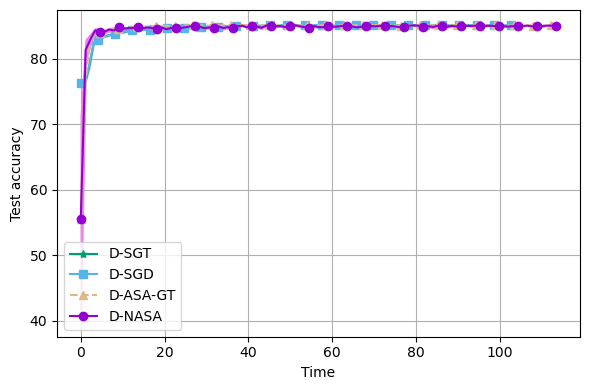

In [10]:
# test accuracy vs. time
for data in ['a9a']:
    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
    plt.xlabel('Time')
    ax.set_ylabel('Test accuracy')
    for k, algo in enumerate(algorithms):
        if algo == 'proxdasagt':
            plt.plot(a9a_time_avg[k], a9a_acc_avg[k], '--', markevery=4, marker=marker_list[k], \
                     label=name_mapping[algo], color = color_list[k])
            plt.fill_between(a9a_time_avg[k], a9a_acc_avg[k]-1.96*a9a_acc_std[k]/np.sqrt(10), \
                         a9a_acc_avg[k]+1.96 * a9a_acc_std[k]/np.sqrt(10), color=shadow_list[k])
        else:
            plt.plot(a9a_time_avg[k], a9a_acc_avg[k], markevery=4, marker=marker_list[k], label=name_mapping[algo], color = color_list[k])
            plt.fill_between(a9a_time_avg[k], a9a_acc_avg[k]-1.96*a9a_acc_std[k]/np.sqrt(10), \
                         a9a_acc_avg[k]+1.96 * a9a_acc_std[k]/np.sqrt(10), color=shadow_list[k])
plt.legend()
plt.grid()
plt.savefig('plots/a9a_acc_time.pdf')
plt.show()

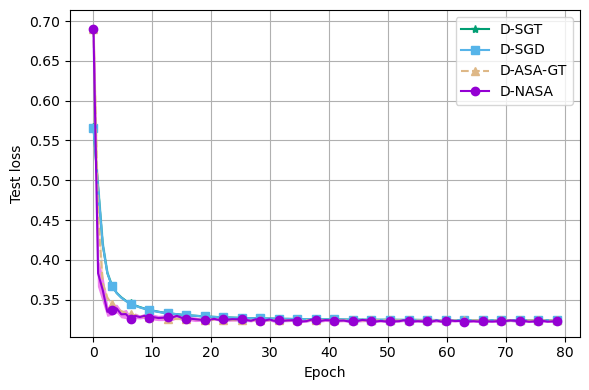

In [11]:
# test loss vs. epoch
for data in ['a9a']:
    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
    plt.xlabel('Epoch')
    ax.set_ylabel('Test loss')
    for k, algo in enumerate(algorithms):
        if algo == 'proxdasagt':
            plt.plot(epoch_list, a9a_test_loss_avg[k], '--', markevery=4, marker=marker_list[k], \
                     label=name_mapping[algo], color=color_list[k])
            plt.fill_between(epoch_list, a9a_test_loss_avg[k]-1.96 * a9a_test_loss_std[k] / np.sqrt(10), \
                             a9a_test_loss_avg[k]+ 1.96 * a9a_test_loss_std[k]/np.sqrt(10), color=shadow_list[k])
        elif algo != 'proxgtsr':
            plt.plot(epoch_list, a9a_test_loss_avg[k], markevery=4, marker=marker_list[k], label=name_mapping[algo], color=color_list[k])
            plt.fill_between(epoch_list, a9a_test_loss_avg[k]-1.96 * a9a_test_loss_std[k] / np.sqrt(10), \
                             a9a_test_loss_avg[k]+ 1.96 * a9a_test_loss_std[k]/np.sqrt(10), color=shadow_list[k])
        else:
            plt.plot(proxgtsr_epoch_list[:gtsr_cut_off], a9a_test_loss_avg[k][:gtsr_cut_off], \
                     marker=marker_list[k], label=name_mapping[algo], color=color_list[k])
            plt.fill_between(proxgtsr_epoch_list[:gtsr_cut_off], \
             a9a_test_loss_avg[k][:gtsr_cut_off]-1.96 * a9a_test_loss_std[k][:gtsr_cut_off]/ np.sqrt(10), \
             a9a_test_loss_avg[k][:gtsr_cut_off]+1.96 *a9a_test_loss_std[k][:gtsr_cut_off]/ np.sqrt(10), color=shadow_list[k])
            
#             plt.plot(epoch_list, a9a_test_loss_avg[k], markevery=4, marker=marker_list[k], label=name_mapping[algo], color=color_list[k])
#             plt.fill_between(epoch_list, a9a_test_loss_avg[k]-1.96 * a9a_test_loss_std[k] / np.sqrt(10), \
#                              a9a_test_loss_avg[k]+ 1.96 * a9a_test_loss_std[k]/np.sqrt(10), color=shadow_list[k])
            
plt.legend()
plt.grid()
plt.savefig('plots/a9a_loss_epo_full.pdf')
plt.show()

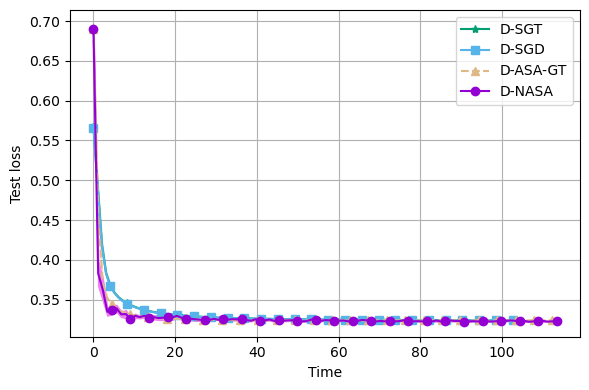

In [12]:
# test loss vs. time

for data in ['a9a']:
    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
    plt.xlabel('Time')
    ax.set_ylabel('Test loss')
    for k, algo in enumerate(algorithms):
        if algo == 'proxdasagt':
            plt.plot(a9a_time_avg[k], a9a_test_loss_avg[k], '--', markevery=4, marker=marker_list[k], label=name_mapping[algo], color = color_list[k])
            plt.fill_between(a9a_time_avg[k], a9a_test_loss_avg[k]-1.96*a9a_test_loss_std[k]/np.sqrt(10), \
                         a9a_test_loss_avg[k]+1.96 * a9a_test_loss_std[k]/np.sqrt(10), color=shadow_list[k])
        else:
            plt.plot(a9a_time_avg[k], a9a_test_loss_avg[k], markevery=4, marker=marker_list[k], label=name_mapping[algo], color = color_list[k])
            plt.fill_between(a9a_time_avg[k], a9a_test_loss_avg[k]-1.96*a9a_test_loss_std[k]/np.sqrt(10), \
                         a9a_test_loss_avg[k]+1.96 * a9a_test_loss_std[k]/np.sqrt(10), color=shadow_list[k])
plt.legend()
plt.grid()
plt.savefig('plots/a9a_loss_time.pdf')
plt.show()

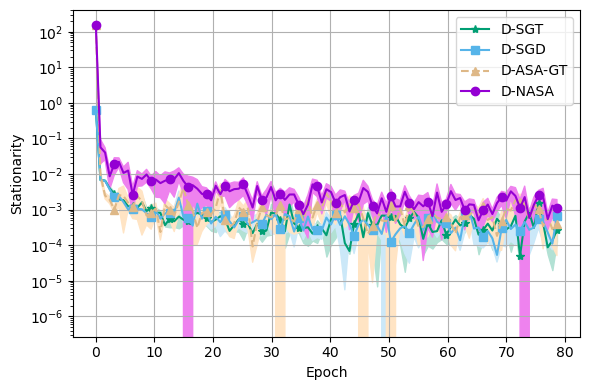

In [13]:
# stationarity vs. epoch
for data in ['a9a']:
    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
    plt.xlabel('Epoch')
    ax.set_ylabel('Stationarity')
    ax.set_yscale('log')
    for k, algo in enumerate(algorithms):
        if algo == 'proxdasagt':
            plt.plot(epoch_list, a9a_stat_avg[k], '--', markevery=4, marker=marker_list[k], label=name_mapping[algo], color=color_list[k])
            plt.fill_between(epoch_list, \
                a9a_stat_avg[k]-1.96 * a9a_stat_std[k] / np.sqrt(10), \
                a9a_stat_avg[k]+ 1.96 * a9a_stat_std[k]/np.sqrt(10), color=shadow_list[k])
        elif algo != 'proxgtsr':
            plt.plot(epoch_list, a9a_stat_avg[k], markevery=4, marker=marker_list[k], label=name_mapping[algo], color=color_list[k])
            plt.fill_between(epoch_list, \
                a9a_stat_avg[k]-1.96 * a9a_stat_std[k] / np.sqrt(10), \
                a9a_stat_avg[k]+ 1.96 * a9a_stat_std[k]/np.sqrt(10), color=shadow_list[k])
        else:
            plt.plot(proxgtsr_epoch_list[:gtsr_cut_off], a9a_stat_avg[k][:gtsr_cut_off], \
                     marker=marker_list[k], label=name_mapping[algo], color=color_list[k])
            plt.fill_between(proxgtsr_epoch_list[:gtsr_cut_off], \
             a9a_stat_avg[k][:gtsr_cut_off]-1.96 * a9a_stat_std[k][:gtsr_cut_off]/ np.sqrt(10), \
             a9a_stat_avg[k][:gtsr_cut_off]+1.96 *a9a_stat_std[k][:gtsr_cut_off]/ np.sqrt(10), color=shadow_list[k])
            
#             plt.plot(epoch_list, a9a_stat_avg[k], markevery=4, marker=marker_list[k], label=name_mapping[algo], color=color_list[k])
#             plt.fill_between(epoch_list, \
#                 a9a_stat_avg[k]-1.96 * a9a_stat_std[k] / np.sqrt(10), \
#                 a9a_stat_avg[k]+ 1.96 * a9a_stat_std[k]/np.sqrt(10), color=shadow_list[k])
            
plt.legend()
plt.grid()
plt.savefig('plots/a9a_stat_epo_full.pdf')
plt.show()

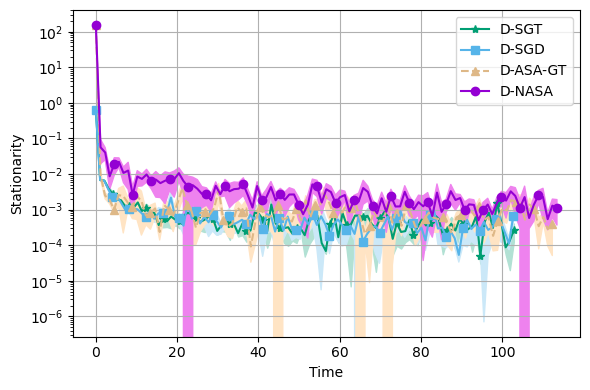

In [14]:
# stationarity vs. time
for data in ['a9a']:
    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
    plt.xlabel('Time')
    ax.set_ylabel('Stationarity')
    ax.set_yscale('log')
    for k, algo in enumerate(algorithms):
        if algo == 'proxdasagt':
            plt.plot(a9a_time_avg[k], a9a_stat_avg[k], '--', markevery=4, marker=marker_list[k], label=name_mapping[algo], color = color_list[k])
            plt.fill_between(a9a_time_avg[k], a9a_stat_avg[k]-1.96*a9a_stat_std[k]/np.sqrt(10), \
                         a9a_stat_avg[k]+1.96 * a9a_stat_std[k]/np.sqrt(10), color=shadow_list[k])
        else:
            plt.plot(a9a_time_avg[k], a9a_stat_avg[k], markevery=4, marker=marker_list[k], label=name_mapping[algo], color = color_list[k])
            plt.fill_between(a9a_time_avg[k], a9a_stat_avg[k]-1.96*a9a_stat_std[k]/np.sqrt(10), \
                         a9a_stat_avg[k]+1.96 * a9a_stat_std[k]/np.sqrt(10), color=shadow_list[k])
plt.legend()
plt.grid()
plt.savefig('plots/a9a_stat_time.pdf')
plt.show()

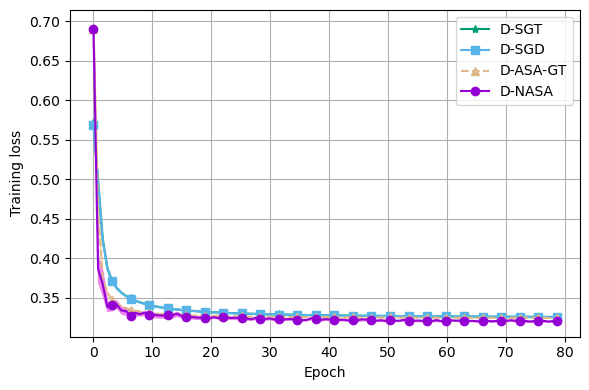

In [15]:
# train loss vs. epoch
for data in ['a9a']:
    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
    plt.xlabel('Epoch')
    ax.set_ylabel('Training loss')
    for k, algo in enumerate(algorithms):
        if algo == 'proxdasagt':
            plt.plot(epoch_list, a9a_train_loss_avg[k], '--', markevery=4, marker=marker_list[k], \
                     label=name_mapping[algo], color=color_list[k])
            plt.fill_between(epoch_list, a9a_train_loss_avg[k]-1.96 * a9a_train_loss_std[k] / np.sqrt(10), \
                             a9a_train_loss_avg[k]+ 1.96 * a9a_train_loss_std[k]/np.sqrt(10), color=shadow_list[k])
        elif algo != 'proxgtsr':
            plt.plot(epoch_list, a9a_train_loss_avg[k], markevery=4, marker=marker_list[k], label=name_mapping[algo], color=color_list[k])
            plt.fill_between(epoch_list, a9a_train_loss_avg[k]-1.96 * a9a_train_loss_std[k] / np.sqrt(10), \
                             a9a_train_loss_avg[k]+ 1.96 * a9a_train_loss_std[k]/np.sqrt(10), color=shadow_list[k])
        else:
            plt.plot(proxgtsr_epoch_list[:gtsr_cut_off], a9a_train_loss_avg[k][:gtsr_cut_off], \
                     marker=marker_list[k], label=name_mapping[algo], color=color_list[k])
            plt.fill_between(proxgtsr_epoch_list[:gtsr_cut_off], \
             a9a_train_loss_avg[k][:gtsr_cut_off]-1.96 * a9a_train_loss_std[k][:gtsr_cut_off]/ np.sqrt(10), \
             a9a_train_loss_avg[k][:gtsr_cut_off]+1.96 *a9a_train_loss_std[k][:gtsr_cut_off]/ np.sqrt(10), color=shadow_list[k])
            
#             plt.plot(epoch_list, a9a_train_loss_avg[k], markevery=4, marker=marker_list[k], label=name_mapping[algo], color=color_list[k])
#             plt.fill_between(epoch_list, a9a_train_loss_avg[k]-1.96 * a9a_train_loss_std[k] / np.sqrt(10), \
#                              a9a_train_loss_avg[k]+ 1.96 * a9a_train_loss_std[k]/np.sqrt(10), color=shadow_list[k])
            
plt.legend()
plt.grid()
plt.savefig('plots/a9a_train_loss_epo_full.pdf')
plt.show()

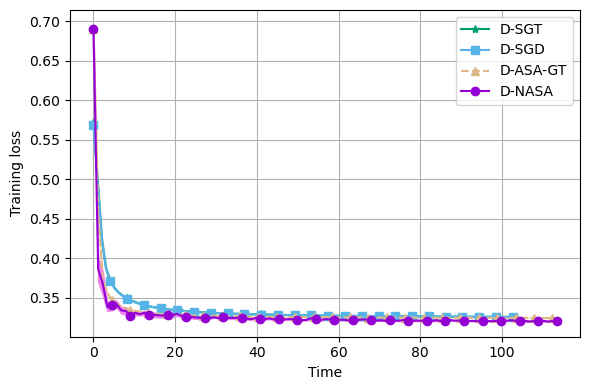

In [16]:
# train loss vs. time

for data in ['a9a']:
    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
    plt.xlabel('Time')
    ax.set_ylabel('Training loss')
    for k, algo in enumerate(algorithms):
        if algo == 'proxdasagt':
            plt.plot(a9a_time_avg[k], a9a_train_loss_avg[k], '--', markevery=4, marker=marker_list[k], label=name_mapping[algo], color = color_list[k])
            plt.fill_between(a9a_time_avg[k], a9a_train_loss_avg[k]-1.96*a9a_train_loss_std[k]/np.sqrt(10), \
                         a9a_train_loss_avg[k]+1.96 * a9a_train_loss_std[k]/np.sqrt(10), color=shadow_list[k])
        else:
            plt.plot(a9a_time_avg[k], a9a_train_loss_avg[k], markevery=4, marker=marker_list[k], label=name_mapping[algo], color = color_list[k])
            plt.fill_between(a9a_time_avg[k], a9a_train_loss_avg[k]-1.96*a9a_train_loss_std[k]/np.sqrt(10), \
                         a9a_train_loss_avg[k]+1.96 * a9a_train_loss_std[k]/np.sqrt(10), color=shadow_list[k])
plt.legend()
plt.grid()
plt.savefig('plots/a9a_train_loss_time.pdf')
plt.show()

In [17]:
trial_num = 1
data = 'a9a'
stepsize_list = ["0.005", "0.01", "0.05", "0.1", "0.5", "1.0", "5.0", "10.0", "50.0"]

res_list = {algo: [] for algo, _ in name_mapping.items()}
for algo, name in name_mapping.items():
    for stepsize in stepsize_list:
        result = np.load(results_prefix + '{}_t_{}_random_{}_{}_lr_{}.npy'.format(algo, 1, batch_size, K, stepsize), allow_pickle=True)
        if algo in ['dsgt', 'dsgd']:
            for idd, res in enumerate(result):
                if len(res) == len(eval_idx) + 1:
                    result[idd] = res[1:]
        
        res_list[algo].append(max(result[1]))  

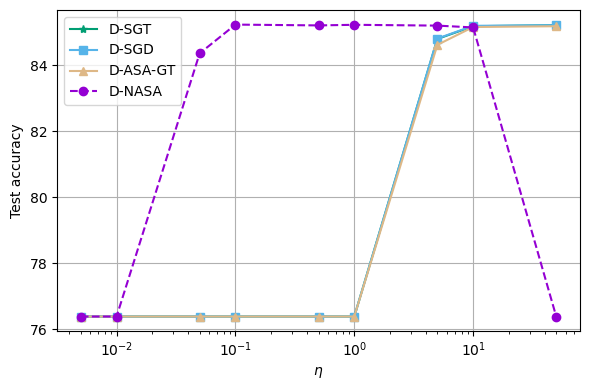

In [18]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
plt.xlabel('$\eta$')
plt.xscale("log")
ax.set_ylabel('Test accuracy')
for k, algo in enumerate(algorithms):
    if algo == 'proxndasagt':
        plt.plot([float(s) for s in stepsize_list], res_list[algo], '--', marker=marker_list[k], label=name_mapping[algo], color = color_list[k])
    else:
        plt.plot([float(s) for s in stepsize_list], res_list[algo], marker=marker_list[k], label=name_mapping[algo], color = color_list[k])
plt.legend()
plt.grid()
plt.savefig('plots/a9a_acc_different_stepsize.pdf')
plt.show()

In [59]:
# trial_num = 1
# data = 'miniboone'
# stepsize_list = ["0.005", "0.01", "0.05", "0.1", "0.5", "1.0", "5.0", "10.0", "50.0"]

# res_list = {algo: [] for algo, _ in name_mapping.items()}
# for algo, name in name_mapping.items():
#     for stepsize in stepsize_list:
#         result = np.load(results_prefix + '{}_t_{}_random_{}_{}_lr_{}.npy'.format(algo, 1, batch_size, K, stepsize), allow_pickle=True)
#         if algo in ['dsgt', 'dsgd']:
#             for idd, res in enumerate(result):
#                 if len(res) == len(eval_idx) + 1:
#                     result[idd] = res[1:]
        
#         res_list[algo].append(max(result[1]))  

# fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
# plt.xlabel('Stepsize')
# plt.xscale("log")
# ax.set_ylabel('Test accuracy')
# for k, algo in enumerate(algorithms):
#     if algo == 'proxndasagt':
#         plt.plot([float(s) for s in stepsize_list], res_list[algo], '--', marker=marker_list[k], label=name_mapping[algo], color = color_list[k])
#     else:
#         plt.plot([float(s) for s in stepsize_list], res_list[algo], marker=marker_list[k], label=name_mapping[algo], color = color_list[k])
# plt.legend()
# plt.grid()
# plt.savefig('miniboone_acc_different_stepsize.pdf')
# plt.show()